In [1]:
from data_prep.data_prep import prepare_all_data
from training.training import prepare_model_data
from model import burglary_model
from utils.utils import single_out_last, setup_reproducibility
from pipeline import train_and_evaluate_model
model_tuple, occupation_mappings,ward_idx_map = prepare_all_data("../merged_data.parquet", "lsoa")

In [2]:
device = setup_reproducibility(42)
print(f'Using device: {device}')
training_data, testing_data = single_out_last(model_tuple[0])

Using device: cuda


In [3]:

# model_tuple = (
#     model_tuple[0],
# ['Ethnic Group|BAME (%)', 'Car or van availability|No cars or vans in household (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|4', 'n_neighbors', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|3', 'Public Transport Accessibility Levels|% 0-1 (poor access)|Level3_65', 'Household Composition|% One person household', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|6a', 'Ethnic Group|Asian/Asian British (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|2', 'Ethnic Group|Black/African/Caribbean/Black British (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|6b', 'Car or van availability|1 car or van in household (%)', 'Ethnic Group|Other ethnic group (%)', 'Tenure|Owned with a mortgage or loan (%)', 'Car or van availability|2 cars or vans in household (%)'],
# ['Mid-year Population Estimates|All Ages', 'Mid-year Population Estimates|Aged 0-15', 'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)', 'Education, Skills and Training Rank (where 1 is most deprived)', 'Mid-year Population Estimates|Aged 45-64', 'Employment Rank (where 1 is most deprived)', 'Income Rank (where 1 is most deprived)'],
# ["post_corona", "month_sin"],
# ['time_log'],
# ['lag_1'],
# ['lag1_diff_neighbors', 'lag1_mean_neighbors', 'lag_1_x_n_neighbors']
# )

In [4]:
train_data = prepare_model_data(training_data, *model_tuple[1:], device, ward_idx_map=ward_idx_map)
test_data = prepare_model_data(testing_data, *model_tuple[1:], device, train_data["means"], train_data["stds"], ward_idx_map)

evaluation_metrics, svi, svi.guide, prediction_tester = train_and_evaluate_model(train_data, test_data, burglary_model, occupation_mappings[1], testing_steps=5000)

Training SVI: 100%|██████████| 500/500 [00:31<00:00, 15.77it/s]


In [5]:
evaluation_metrics

{'rmse': np.float32(1.8593796),
 'mae': np.float32(1.150282),
 'crps': 2.9864696866049125}

# Explainability

In [6]:
# posterior predictive samples:   preds  (shape: [S, N])   – integers
# posterior rate samples:         lam    (shape: [S, N])   – reals
# design-matrix DataFrame:        X_df   (one row per LSOA month)
# original GeoJSON for LSOAs:     lsoa_geo
import geopandas as gpd
preds = prediction_tester.predictions["obs"].cpu().numpy()    # shape (1000, N)
lam   = prediction_tester.predictions["lam"].cpu().numpy()    # shape (1000, N)
X_df = testing_data.copy()
X_df["lsoa"] = X_df["occupation_idx"].map(occupation_mappings[1])
lsoa_geo = gpd.read_file("../processed_data/LSOA boundaries.geojson")

In [7]:
X_df["lsoa"]

171       E01000001
343       E01000002
515       E01000003
687       E01000005
859       E01000006
            ...    
853119    E01035688
853291    E01035689
853463    E01035690
853635    E01035691
853807    E01035692
Name: lsoa, Length: 4964, dtype: object

In [8]:
lsoa_geo = lsoa_geo[["LSOA21CD", "geometry"]].rename(columns={"LSOA21CD": "lsoa"}).copy()

In [9]:
X_df["burglaries"]

171       0.0
343       0.0
515       1.0
687       1.0
859       0.0
         ... 
853119    4.0
853291    0.0
853463    4.0
853635    0.0
853807    3.0
Name: burglaries, Length: 4964, dtype: float32

In [10]:
X_df[["occupation_idx", "burglaries"]].assign(lsoa=X_df["occupation_idx"].map(occupation_mappings[1])).set_index("lsoa")[["burglaries"]]

,burglaries
lsoa,
E01000001,0.0
E01000002,0.0
E01000003,1.0
E01000005,1.0
E01000006,0.0
...,...
E01035688,4.0
E01035689,0.0
E01035690,4.0


In [11]:
prediction_tester.get_confidence_intervals(0.05)

,lower_bound,upper_bound
E01000001,0.0,1.0
E01000002,0.0,3.0
E01000003,0.0,2.0
E01000005,0.0,4.0
E01000006,0.0,12.0
...,...,...
E01035688,0.0,4.0
E01035689,0.0,6.0
E01035690,0.0,26.0
E01035691,0.0,19.0


In [12]:
prediction_tester.get_confidence_intervals(0.05).reset_index(names="lsoa")

,lsoa,lower_bound,upper_bound
0,E01000001,0.0,1.0
1,E01000002,0.0,3.0
2,E01000003,0.0,2.0
3,E01000005,0.0,4.0
4,E01000006,0.0,12.0
...,...,...,...
4959,E01035688,0.0,4.0
4960,E01035689,0.0,6.0
4961,E01035690,0.0,26.0
4962,E01035691,0.0,19.0


In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume you already have:
#   ci_df       : DataFrame with columns ["lsoa", "lower_bound", "upper_bound"]
#   summary_df  : DataFrame with columns ["lsoa", "burglaries_observed"] (and possibly other cols)
summary_df = X_df[["occupation_idx", "burglaries"]].assign(lsoa=X_df["occupation_idx"].map(occupation_mappings[1])).set_index("lsoa")[["burglaries"]].reset_index()

In [14]:
import numpy as np
alphas = np.arange(0.05, 1, 0.05)
coverages = []
confidence_intervals = []
for alpha in alphas:
    ci_df = prediction_tester.get_confidence_intervals(alpha).reset_index(names="lsoa")
    test = ci_df.merge(summary_df, on="lsoa", how="left")
    test["contained"] = (test["lower_bound"] <= test["burglaries"]) &  (test["burglaries"] <= test["upper_bound"])
    coverages.append(test["contained"].mean() * 100)
    confidence_intervals.append((test["upper_bound"] - test["lower_bound"]).mean())

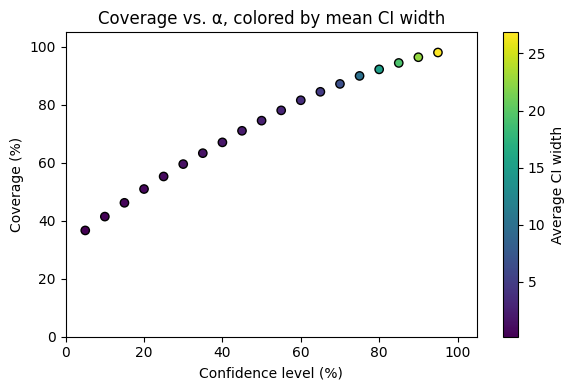

In [15]:
import numpy as np
import matplotlib.pyplot as plt

confidence = (1 - alphas) * 100  
# 2. Scatter plot: alpha vs coverage, colored by mean CI width
fig, ax = plt.subplots(figsize=(6, 4))
sc = ax.scatter(confidence, coverages, c=confidence_intervals, cmap='viridis', edgecolor='k')
ax.set_xlabel("Confidence level (%)")
ax.set_ylabel("Coverage (%)")
ax.set_title("Coverage vs. α, colored by mean CI width")
ax.set_xlim(0, 105)
ax.set_ylim(0, 105)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Average CI width")
plt.tight_layout()
plt.show()


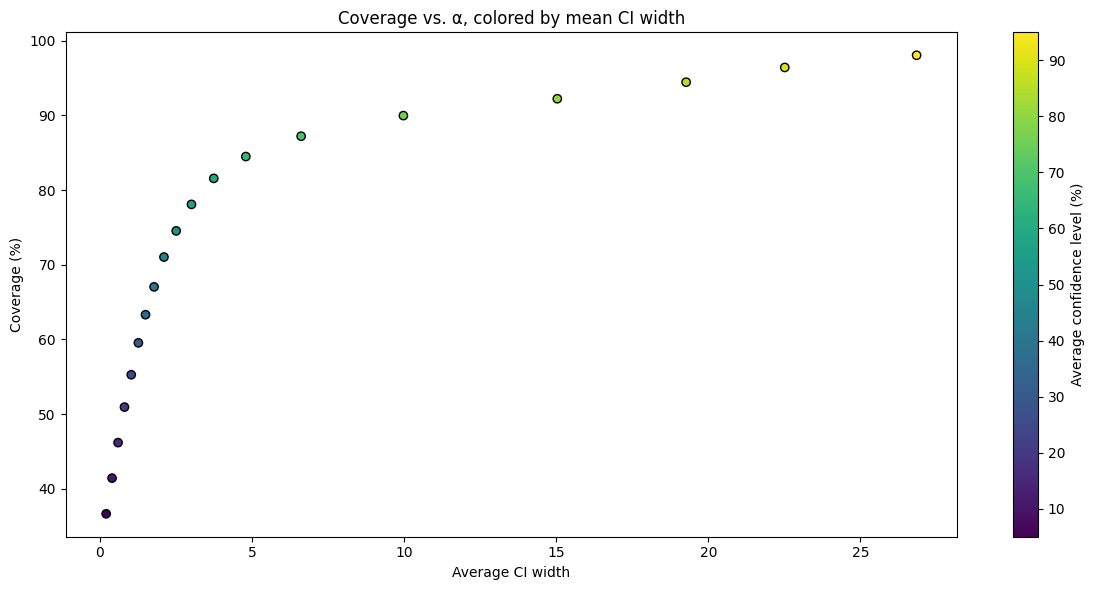

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter(confidence_intervals,  coverages, c=confidence, cmap='viridis', edgecolor='k')
ax.set_xlabel("Average CI width")
ax.set_ylabel("Coverage (%)")
ax.set_title("Coverage vs. α, colored by mean CI width")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Average confidence level (%)")
plt.tight_layout()
plt.show()

In [17]:
from testing.testing import StatisticalTester
factors_map ={
    "b_static": model_tuple[1],
    "b_dynamic": model_tuple[2],
    "b_seasonal": model_tuple[3],
    "b_time_tr": model_tuple[4],
    "b_temporal": model_tuple[5],
    "b_spatial": model_tuple[6],
}
statistical_tester = StatisticalTester(test_data, burglary_model, svi.guide, factors_map)

In [18]:
statistical_tester.predict(5000)

In [19]:
alpha_1 = 0.01
frames = statistical_tester.evaluate_all(alpha=alpha_1)

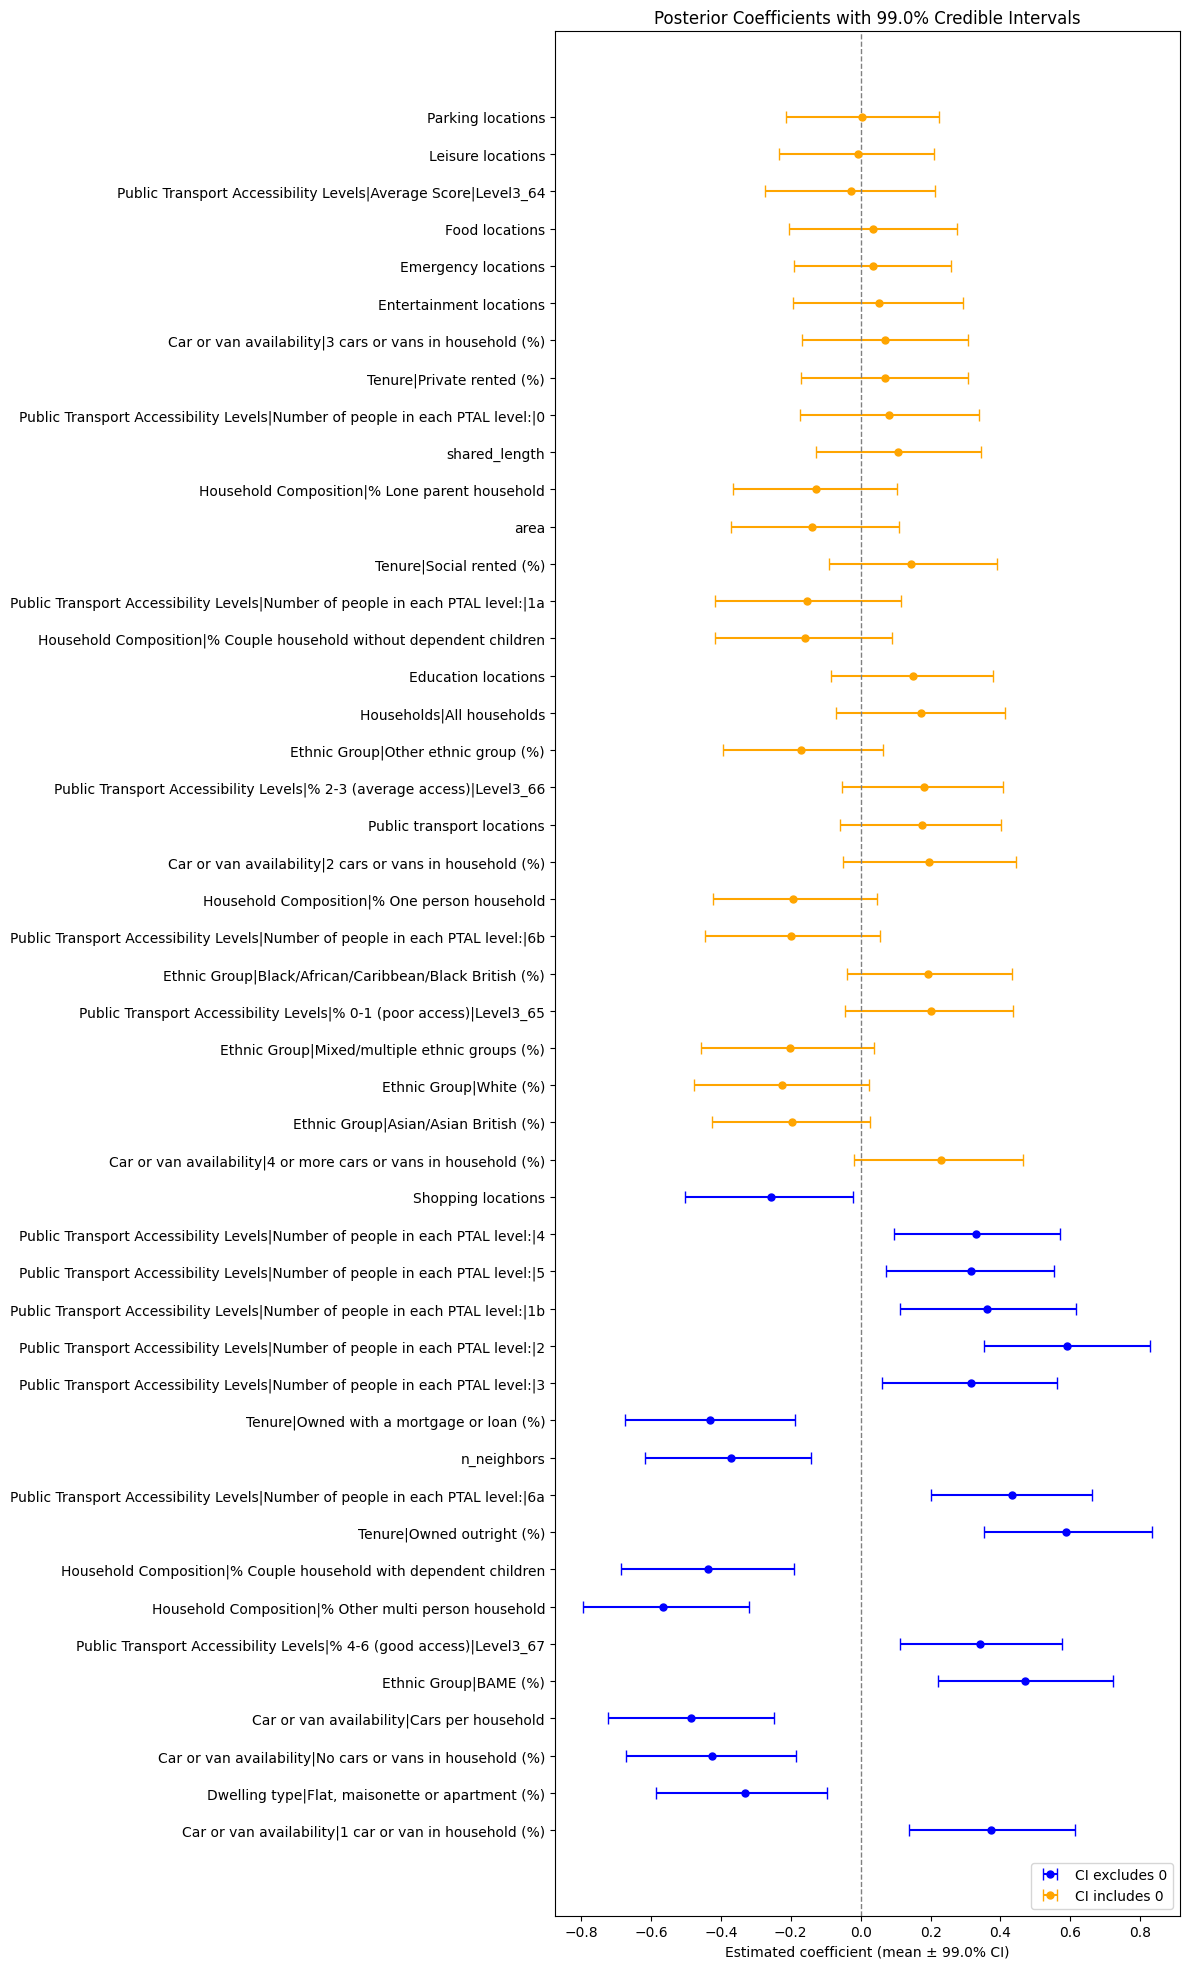

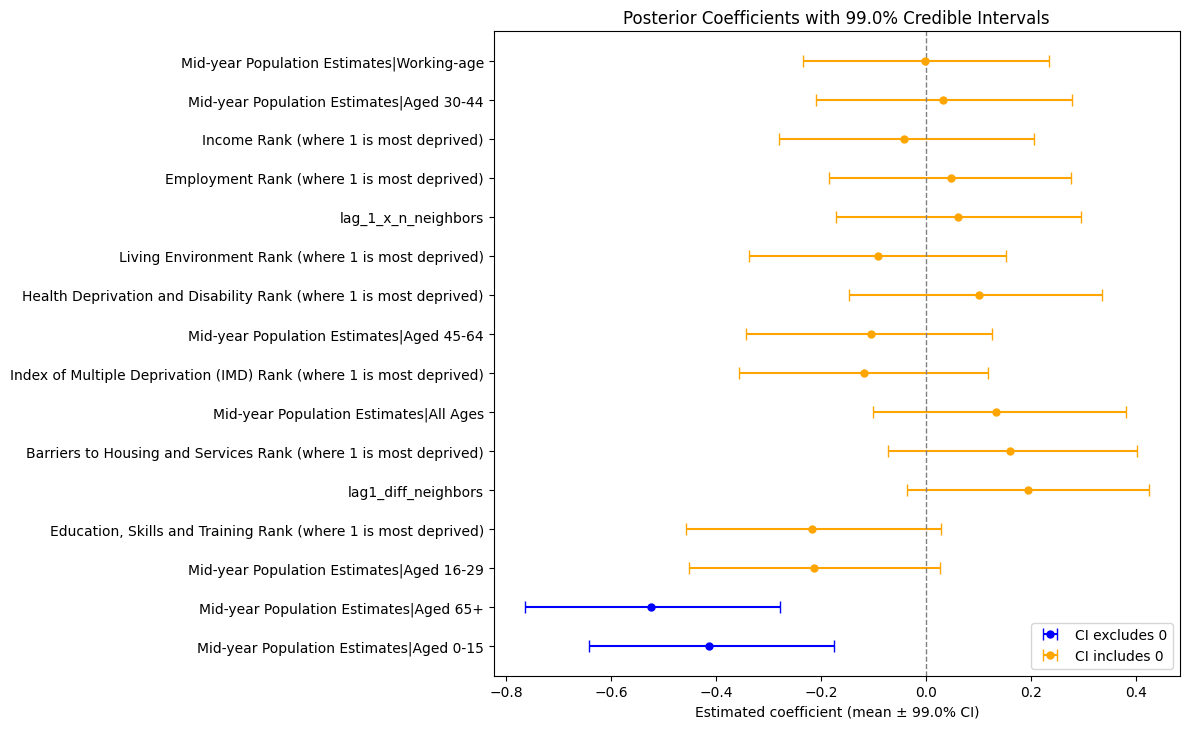

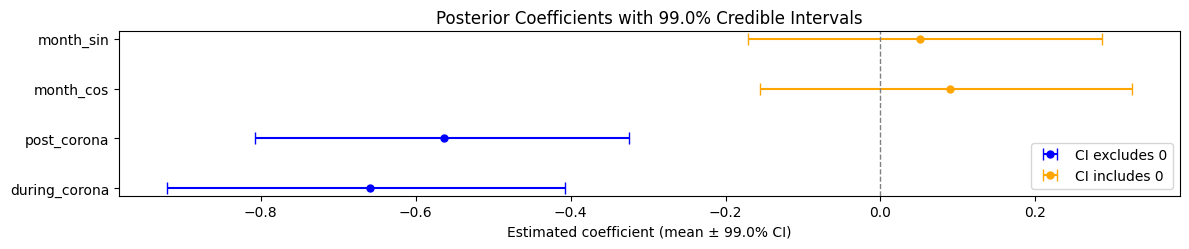

c:\MiniConda\envs\py311\Lib\site-packages\matplotlib\cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


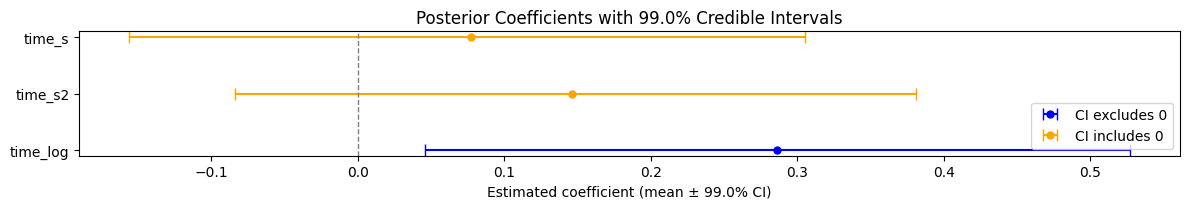

c:\MiniConda\envs\py311\Lib\site-packages\matplotlib\cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


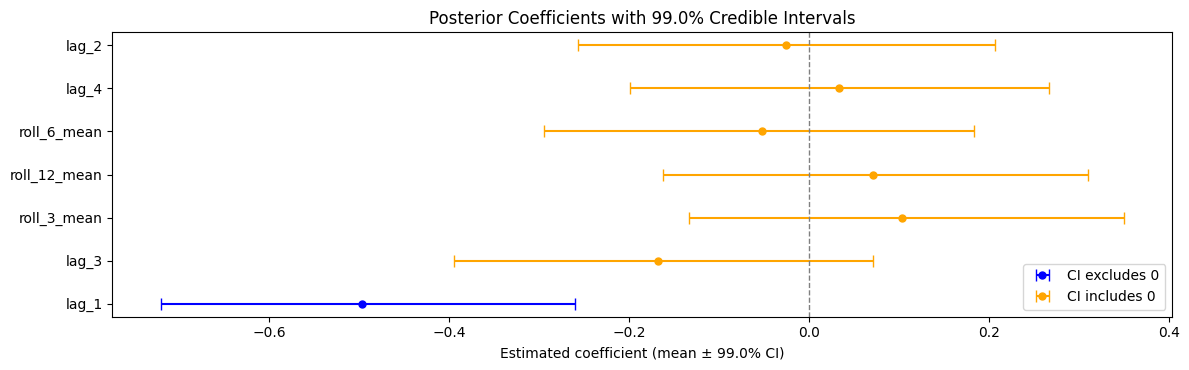

c:\MiniConda\envs\py311\Lib\site-packages\matplotlib\cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


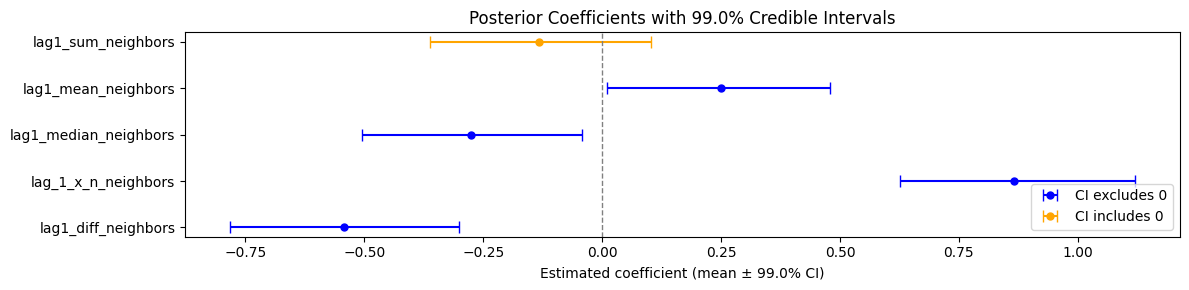

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Loop through each DataFrame in frames
for alpha, df in frames.items():
    # 1. Compute the lower and upper error magnitudes
    lower_err = df['mean'] - df['ci_lower']
    upper_err = df['ci_upper'] - df['mean']

    # Identify which intervals contain zero
    contains_zero = (df['ci_lower'] <= 0) & (df['ci_upper'] >= 0)

    # 2. Prepare figure
    fig, ax = plt.subplots(figsize=(12, 0.4 * len(df) + 1))

    # 3a. Plot those NOT containing zero in default color (blue)
    ypos = np.arange(len(df))
    ax.errorbar(
        df.loc[~contains_zero, 'mean'],
        ypos[~contains_zero],
        xerr=[lower_err[~contains_zero], upper_err[~contains_zero]],
        fmt='o',
        capsize=4,
        markersize=5,
        color='blue',
        label='CI excludes 0'
    )

    # 3b. Plot those containing zero in orange
    ax.errorbar(
        df.loc[contains_zero, 'mean'],
        ypos[contains_zero],
        xerr=[lower_err[contains_zero], upper_err[contains_zero]],
        fmt='o',
        capsize=4,
        markersize=5,
        color='orange',
        label='CI includes 0'
    )

    # 4. Add aesthetics
    ax.set_yticks(ypos)
    ax.set_yticklabels(df['col'])
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_xlabel(f'Estimated coefficient (mean ± {100*(1-alpha_1)}% CI)')
    ax.set_title(f'Posterior Coefficients with {(1-alpha_1)*100}% Credible Intervals')
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

In [72]:
import plotly.graph_objects as go

# Loop through each DataFrame in frames and create a dark‐themed Plotly figure
for alpha, df in frames.items():
    # 1. Compute error bar magnitudes
    lower_err = df['mean'] - df['ci_lower']
    upper_err = df['ci_upper'] - df['mean']
    contains_zero = (df['ci_lower'] <= 0) & (df['ci_upper'] >= 0)

    # 2. Initialize figure with dark theme
    fig = go.Figure(layout=dict(
        template="plotly_dark",              # built-in dark template :contentReference[oaicite:2]{index=2}
        paper_bgcolor="black",               # full black canvas :contentReference[oaicite:3]{index=3}
        plot_bgcolor="black",                # black plotting area
    ))

    # 3a. Plot intervals excluding zero (blue markers)
    fig.add_trace(go.Scatter(
        x=df.loc[~contains_zero, 'mean'],
        y=df.loc[~contains_zero, 'col'],
        error_x=dict(
            type='data',
            symmetric=False,
            array=upper_err[~contains_zero],
            arrayminus=lower_err[~contains_zero],
            thickness=2,
            width=5
        ),
        mode='markers',
        marker=dict(color='cyan', size=8),  # brighter marker for contrast
        name='CI excludes 0'
    ))

    # 3b. Plot intervals including zero (orange markers)
    fig.add_trace(go.Scatter(
        x=df.loc[contains_zero, 'mean'],
        y=df.loc[contains_zero, 'col'],
        error_x=dict(
            type='data',
            symmetric=False,
            array=upper_err[contains_zero],
            arrayminus=lower_err[contains_zero],
            thickness=2,
            width=5
        ),
        mode='markers',
        marker=dict(color='orange', size=8),
        name='CI includes 0'
    ))

    # 4. Vertical zero reference line in white
    fig.add_shape(
        type="line",
        x0=0, x1=0,
        y0=-0.5, y1=len(df)-0.5,
        xref="x", yref="y",
        line=dict(color="white", dash="dash", width=2)
    )

    # 5. Layout and axes adjustments
    fig.update_layout(
        title=f'Posterior Coefficients ({(1-alpha_1)*100:.1f}% CI)',
        xaxis_title=f'Coefficient estimate ± {(1-alpha_1)*100:.1f}% CI',
        yaxis_title='Feature',
        height=300 + 25 * len(df),
        margin=dict(l=150, r=50, t=100, b=50),
        legend=dict(bgcolor='rgba(0,0,0,0)'),  # transparent legend background
    )

    # 6. Preserve DataFrame order on the y‐axis (inverted)
    fig.update_yaxes(
        categoryorder='array',
        categoryarray=df['col'].tolist()[::-1]
    )

    fig.show()


In [21]:
y_obs = prediction_tester.get_median_predictions().values              # 1-D arraylike of observed burglaries for the target month (length = n_lsoa)
posterior_samples = prediction_tester.predictions["obs"].cpu().numpy()  # 2-D ndarray (n_draws × n_lsoa) from pyro.infer.Predictive(...)
X = model_tuple[0].copy()                  # pandas DataFrame of feature values used at prediction time (n_lsoa × p)
# geo_lsoa =           # GeoDataFrame with an identical index, WGS84 geometry, and an "lsoa_code" column


In [22]:
# # Cell 2 – Calibration Curve
# import pandas as pd
# from scipy.stats import percentileofscore

# quantiles = np.arange(5, 100, 5)           # 5 % steps
# coverage  = []

# for q in quantiles:
#     q_lo = np.percentile(y_rep, 50 - q/2, axis=0)
#     q_hi = np.percentile(y_rep, 50 + q/2, axis=0)
#     inside = (y_obs >= q_lo) & (y_obs <= q_hi)
#     coverage.append(inside.mean())         # proportion actually covered

# fig, ax = plt.subplots()
# ax.plot(quantiles/100, coverage, marker="o", label="Model")
# ax.plot([0,1], [0,1], "--", label="Ideal")
# ax.set_xlabel("Posterior interval nominal level")
# ax.set_ylabel("Observed coverage")
# ax.set_title("Calibration / Reliability Diagram")
# ax.legend()
# plt.show()


In [23]:
model_tuple[1:]

(['Car or van availability|1 car or van in household (%)',
  'Car or van availability|2 cars or vans in household (%)',
  'Car or van availability|3 cars or vans in household (%)',
  'Car or van availability|4 or more cars or vans in household (%)',
  'Car or van availability|Cars per household',
  'Car or van availability|No cars or vans in household (%)',
  'Dwelling type|Flat, maisonette or apartment (%)',
  'Education locations',
  'Emergency locations',
  'Entertainment locations',
  'Ethnic Group|Asian/Asian British (%)',
  'Ethnic Group|BAME (%)',
  'Ethnic Group|Black/African/Caribbean/Black British (%)',
  'Ethnic Group|Mixed/multiple ethnic groups (%)',
  'Ethnic Group|Other ethnic group (%)',
  'Ethnic Group|White (%)',
  'Food locations',
  'Household Composition|% Couple household with dependent children',
  'Household Composition|% Couple household without dependent children',
  'Household Composition|% Lone parent household',
  'Household Composition|% One person househo

In [43]:
corr = model_tuple[0].corr().abs()
labels_trunc = [f"  {col[:20]}  " for col in corr.columns]

In [44]:
import numpy as np
import pandas as pd
import plotly.express as px

# 2) Truncate labels to first 15 characters

# 3) Create the interactive heatmap with the dark template
fig = px.imshow(
    corr.values.round(2),
    x=labels_trunc,
    y=labels_trunc,
    color_continuous_scale="Viridis",    # colorblind-friendly
    zmin=0,
    zmax=1,
    aspect="equal",                      # square cells
    template="plotly_dark",              # ← use the dark theme :contentReference[oaicite:0]{index=0}
    # title="Feature Correlation Heatmap"
)

# 4) Show every 5th tick to prevent overlap
n = len(labels_trunc)
step = 5
fig.update_xaxes(
    tickmode="array",
    tickvals=list(range(0, n, step)),
    ticktext=[labels_trunc[i] for i in range(0, n, step)],
    tickangle=90
)
fig.update_yaxes(
    tickmode="array",
    tickvals=list(range(0, n, step)),
    ticktext=[labels_trunc[i] for i in range(0, n, step)],
    autorange="reversed",
)

# 5) (Optional) Force the plot background to true black for maximum contrast
fig.update_layout(
    paper_bgcolor="black",
    plot_bgcolor="black",
    coloraxis_colorbar=dict(
        thickness=15,
        title="Correlation"
    ),
    width=600,
    height=600,
    margin=dict(l=0, r=0, t=0, b=0)
)

fig.show()

In [26]:
import pandas as pd
import numpy as np

# 1. Compute the absolute correlation matrix

# 2. Zero out the lower triangle and the diagonal
#    so we only inspect each pair once, and drop self‐correlations
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
upper = corr.where(mask)

# 3. “Unpivot” to a long form and filter
high_corr = (
    upper
    .stack()                             # turns into a Series indexed by (feature1, feature2)
    .reset_index()                       # DataFrame with columns ['level_0','level_1', 0]
    .rename(columns={'level_0':'feature1','level_1':'feature2', 0:'correlation'})
    .query('correlation > 0.9')         # keep only those above 0.9
    .sort_values('correlation', ascending=False)
    .reset_index(drop=True)
)

In [27]:
high_corr

,feature1,feature2,correlation
0,Ethnic Group|BAME (%),Ethnic Group|White (%),1.000000
1,Car or van availability|2 cars or vans in hous...,Car or van availability|Cars per household,0.980510
2,time_s,time_s2,0.975457
3,Car or van availability|Cars per household,Car or van availability|No cars or vans in hou...,0.968567
4,time_s,time_log,0.954563
5,lag_1,lag_1_x_n_neighbors,0.947524
6,roll_6_mean,roll_12_mean,0.944531
7,Car or van availability|2 cars or vans in hous...,Car or van availability|No cars or vans in hou...,0.938554
8,Car or van availability|3 cars or vans in hous...,Car or van availability|Cars per household,0.923730
9,Mid-year Population Estimates|All Ages,Mid-year Population Estimates|Working-age,0.922528


In [45]:
df = pd.read_parquet("../merged_data.parquet")

<Axes: xlabel='date'>

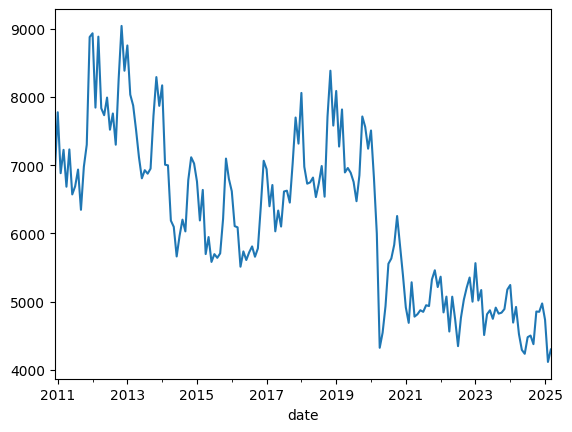

In [52]:
df.groupby("date")["Burglaries amount"].sum().plot()

In [66]:
import plotly.graph_objects as go
import pandas as pd
from plotly.colors import qualitative

# Replace this with your actual DataFrame
crime_df = df.copy()  

# 1. Monthly burglary totals
monthly = crime_df.groupby("date")["Burglaries amount"].sum().reset_index()
monthly["date"] = pd.to_datetime(monthly["date"])

# 2. Key event periods
events = [
    {"Event": "2012 Olympics",        "Start": "2012-05-27", "End": "2012-10-12"},
    {"Event": "Brexit Referendum",    "Start": "2016-05-23", "End": "2016-07-23"},
    {"Event": "Knife Crime Peak",     "Start": "2017-01-01", "End": "2018-12-31"},
    {"Event": "COVID Lockdowns",      "Start": "2020-01-23", "End": "2021-06-30"},
    {"Event": "Post-Pandemic Surge",  "Start": "2021-06-30", "End": "2023-12-31"},
]
for ev in events:
    ev["Start"] = pd.to_datetime(ev["Start"])
    ev["End"]   = pd.to_datetime(ev["End"])

# 3. Assign each event a distinct color
palette = qualitative.Plotly  # has at least 10 distinct colors
colors = {ev["Event"]: palette[i % len(palette)] for i, ev in enumerate(events)}

# 4. Build figure
fig = go.Figure()

for ev in events:
    color = colors[ev["Event"]]
    # shaded band
    fig.add_shape(
        type="rect",
        x0=ev["Start"], x1=ev["End"],
        y0=0, y1=1,
        xref="x", yref="paper",
        fillcolor=color,
        opacity=0.15,
        line_width=0
    )
    # centered label above the band
    fig.add_annotation(
        x=ev["Start"] + (ev["End"] - ev["Start"]) / 2,
        y=1.05,
        xref="x", yref="paper",
        text=ev["Event"],
        showarrow=False,
        font=dict(color=color, size=14, family="Arial"),
        align="center"
    )

# 5. Add burglary time series
fig.add_trace(go.Scatter(
    x=monthly["date"],
    y=monthly["Burglaries amount"],
    mode="lines",
    name="Monthly Burglaries",
    line=dict(color="lime", width=2)
))

# 6. Layout tweaks
fig.update_layout(
    template="plotly_dark",
    title="Monthly Burglaries with Key Events Overlay",
    xaxis_title="Date",
    yaxis_title="Number of Burglaries",
    height=600,
    margin=dict(l=80, r=20, t=100, b=50),
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False)
)

fig.show()
